In [ ]:
%cd ..
from jax import value_and_grad, jit
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import pickle
from time import time
from functools import partial
from stencilnet.finite_volume import generate_rectilinear_mesh, u0, advection_solver
from stencilnet.model import init_mlp_params
from stencilnet.optim import mse, symmetry_regularization, update_params

%cd examples/

/home/jp7427/.conda/envs/cupy-env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/jp7427/Desktop/stencilNet
/home/jp7427/Desktop/stencilNet/examples


/home/jp7427/.conda/envs/cupy-env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# mlp
KEY = random.PRNGKey(1)

params = init_mlp_params(KEY, (9, 4, 1))

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
# domain
n = 64
x, y = generate_rectilinear_mesh((0, 1), (0, 1), n)
u_init = u0(x, y, type="square")

advection_solver_config = dict(
    u_init=u_init,
    h=(1 / n, 1 / n),
    v=(2, 1),
    T=1,
    cfl=0.8,
    p=3,
    forward="rk4",
    limit_slopes=True,
)

In [4]:
# execute solver
U_before_training = advection_solver(
    **advection_solver_config,
    theta_limiting_params=params,
)

CPU times: user 3.8 s, sys: 86.8 ms, total: 3.89 s
Wall time: 3.88 s


In [5]:
@partial(jit, static_argnums=(1,))
def loss(params, type: str):
    U = advection_solver(
        **advection_solver_config,
        theta_limiting_params=params,
    )
    reg_loss = symmetry_regularization(params)
    if type == "mse":
        mse_loss = mse(U[-1], U[0])
        return mse_loss + reg_loss
    elif type == "mpp":
        mpp_loss = jnp.mean(jnp.square(jnp.where(U[-1] < 0, U[-1], 0))) + jnp.mean(
            jnp.square(jnp.where(U[-1] > 1, U[-1], 0))
        )
        return mpp_loss + reg_loss


for _ in range(10):
    strt = time()
    loss_val, grads = value_and_grad(partial(loss, type="mse"))(params)
    print(f"Computed loss of {loss_val:.5f} in {time()-strt:.2f}s")
    params = update_params(params, grads, 0.2)

Computed loss of 0.05328 in 125.01s
Computed loss of 0.05209 in 90.27s
Computed loss of 0.05088 in 91.66s
Computed loss of 0.04966 in 91.21s
Computed loss of 0.04844 in 89.59s
Computed loss of 0.04721 in 90.29s
Computed loss of 0.04599 in 90.59s
Computed loss of 0.04479 in 90.54s
Computed loss of 0.04363 in 89.97s
Computed loss of 0.04256 in 90.54s


In [6]:
# execute solver
U_after_training = advection_solver(
    **advection_solver_config,
    theta_limiting_params=params,
)

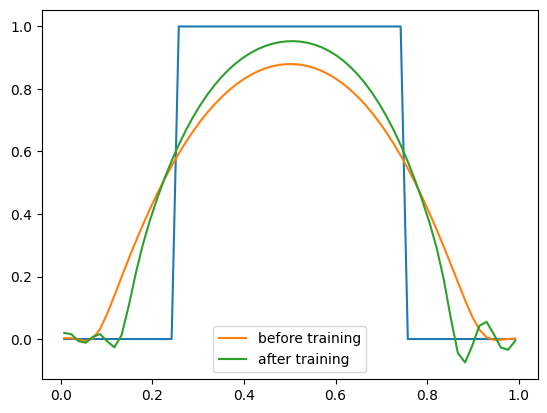

In [7]:
# plot
plt.plot(x[0], U_before_training[0, int(n / 2), :])
plt.plot(x[0], U_before_training[-1, int(n / 2), :], label="before training")
plt.plot(x[0], U_after_training[-1, int(n / 2), :], label="after training")
plt.legend()
plt.show()

In [8]:
%cd ..
with open("models/params.pickle", "wb") as f:
    pickle.dump(params, f)
%cd examples/

/home/jp7427/Desktop/stencilNet


FileNotFoundError: [Errno 2] No such file or directory: 'models/params.pickle'

In [ ]:
%cd ..
with open("models/params.pickle", "rb") as f:
    params_loaded = pickle.load(f)
%cd examples/